<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>


   ##  2D Realization Post-processing in Python for Engineers and Geoscientists 

### with GSLIB's SGSIM and POSTSIM Program Converted to Python

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

#### POSTSIM reimplemented in Python by Javier Santos and Jose Mejia, PhD students, the University of Texas at Austin


This is a tutorial for / demonstration of realization post-processing with **Sequential Gaussian Simulation (SGSIM) program and realization post-processing (POSTSIM) reimplimented in Python from the original FORTRAN GSLIB: Geostatistical Library methods** (Deutsch and Journel, 1997). 

### PGE 383 Exercise: Methods for Summarizing Uncertainty Over Realizations with GeostatsPy

Here's a simple workflow for realization post-processing. This method is ciritical for:

* Quantifying local uncertainty away from wells.

First let's explain the concept of realization post-processing.

#### Realization Post-processing




#### Objective 

In the PGE 383: Stochastic Subsurface Modeling class I want to provide hands-on experience with building subsurface modeling workflows. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - sample_data_MV_biased.csv available at https://git.io/fhgu0.

There are exampled below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 


#### Load the Required Libraries

The following code loads the required libraries.

In [5]:
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

We will also need some standard packages. These should have been installed with Anaconda 3.

In [6]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting


If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

Appreciation to Javier Santos and Jose Mejia (UT PGE PhD students in the Texas Center for Geostatistics) for their assistance with the following program for summarization over multiple realizations.  This function reads in the multiple realizations and produces statistical summaries that we will cover below.  It will shortly be added to GeostatsPy.

In [68]:
def postsim(sims, z_value, cdf_value=0.5):

    """
    Reimplimented in Python by Javier Santos and Jose Merdina from the original FORTRAN function by 
    Deutsch and Journel (1997) GSLIB: Geostatistical Library (www.GSLIB.com)
    
    Post Process Simulated Realizations.
    Reads in a set of simulated realizations as a collection of 2D maps into a 3D array and post 
    process them according to user speficications. 
    -Compute the E-type mean
    -Given a Z-value the program will compute the probability of 
    exceeding the cutoff and the mean value above (and below) the cutoff.
    -Given a CDF value the program will compute the corresponding Z-percentile
    -Symmetric "P" probability interval
    -Conditional variances
    
    Inputs
    
    sims            input realizations (3D matrix)
    z_value         Threshold value
    cdf_value       CDF value to compute
    
    Outputs:
    e_type   e-type mean
    c_var    conditional variance
    prob     Probability of exceeding the z_value
    prob_not
    slice_values_ex
    slice_values_noex
    z_type  symetric probability intervals
    z_type_low
    z_type_high
    
    """
    
    """ Input check """
    if sims.ndim != 3:
        raise ValueError("Array must a 3D (collection of 2D maps)")
    if cdf_value <= 0 :
        print ("Invalid p-value")
        sys.exit()
    else:
        pass         
    if   cdf_value >= 1 :  
        print ("Invalid p-value")
        sys.exit()
    else:
        pass
  
    
    nx    = np.shape(sims)[0]
    ny    = np.shape(sims)[1]
    nsims = np.shape(sims)[2]
    
      
    """ Initialize arrays """
    cdf               = np.zeros(  nsims  )
    prob              = np.zeros( (nx,ny) )
    slice_values_ex   = np.zeros( (nx,ny) )
    slice_values_noex = np.zeros( (nx,ny) )
    
    """ Set up cdf """
    cdf_incr = 1/nsims
    cdf[0]   = cdf_incr/2
    
    for i in range(1,nsims):
        cdf[i] = cdf[i-1] + cdf_incr
       
    if cdf_value < cdf[ 0] : cdf_value = cdf[ 0]
    if cdf_value > cdf[-1] : cdf_value = cdf[-1]
    
    #  Frontran code
    #  call locate(cdf,nsim,1,nsim,outpar,iii)
    #  wtiii  = (outpar-cdf(iii))/(cdf(iii+1)-cdf(iii))
    #  wtiiii = 1.0 - wtiii
    
    cdf_tmp     = cdf[ cdf <= cdf_value ]
    cdf_index_Z = np.where( cdf==cdf_tmp[-1] )[0]
    #cdf_index = cdf[np.abs(cdf_tmp-cdf_value).argmin()]
    #cdf_index = np.where( cdf==cdf_index )[0]
    
    w_Z_1 = (cdf_value-cdf[cdf_index_Z])/(cdf[cdf_index_Z+1]-cdf[cdf_index_Z])
    w_Z_2 = 1 - w_Z_1
    
    cdf_low      = (1-cdf_value)/2
    cdf_tmp      = cdf[cdf <= cdf_low]
    cdf_index_Z1 = np.where( cdf==cdf_tmp[-1] )[0]
    
    w_Z1_1 = (cdf_value-cdf[cdf_index_Z1])/(cdf[cdf_index_Z1+1]-cdf[cdf_index_Z1])
    w_Z1_2 = 1 - w_Z1_1
    
    cdf_high     = (1+cdf_value)/2
    cdf_tmp      = cdf[cdf <= cdf_high]
    cdf_index_Z2 = np.where( cdf==cdf_tmp[-1] )[0]
    
    ##check
    if cdf_index_Z2==nsims-1 : cdf_index_Z2 = cdf_index_Z2-1
    
    w_Z2_1 = (cdf_value-cdf[cdf_index_Z2])/(cdf[cdf_index_Z2+1]-cdf[cdf_index_Z2])
    w_Z2_2 = 1 - w_Z2_1
    
    
    sims_sorted = np.sort( np.copy(sims) )
    e_type      = np.copy(sims).mean(axis=2)
    c_var       = np.sum( sims*sims, axis=2 )/nsims - e_type*e_type
    
    z_type      = sims_sorted[:,:,cdf_index_Z   ]*w_Z_1 + \
                  sims_sorted[:,:,cdf_index_Z+1 ]*w_Z_2
    z_type_low  = sims_sorted[:,:,cdf_index_Z1  ]*w_Z1_1 + \
                  sims_sorted[:,:,cdf_index_Z1+1]*w_Z1_2
    z_type_high = sims_sorted[:,:,cdf_index_Z2  ]*w_Z2_1 + \
                  sims_sorted[:,:,cdf_index_Z2+1]*w_Z2_2
    
    z_type      = z_type.squeeze() #removes singleton dimension
    z_type_low  = z_type_low.squeeze()
    z_type_high = z_type_high.squeeze()
    
    
    for i in range(0,nsims):
        sorted_slice      = sims_sorted[:,:,i]
        mask_exceed       = (sorted_slice >= z_value) 
        prob              = prob + mask_exceed
        slice_values_ex[mask_exceed]     = slice_values_ex[mask_exceed] + \
                                           sorted_slice[mask_exceed]
                                           
        slice_values_noex[1-mask_exceed] = slice_values_noex[1-mask_exceed] + \
                                           sorted_slice[1-mask_exceed]
        

    slice_values_ex  [ slice_values_ex==0   ] = np.nan
    slice_values_noex[ slice_values_noex==0 ] = np.nan
    
    
    prob_not = nsims-prob
    prob_not[ prob_not==0 ] = np.nan
    
    slice_values_ex   = slice_values_ex/prob
    slice_values_noex = slice_values_noex/prob_not
    
    slice_values_ex  [ slice_values_ex==np.nan ] = 0
    slice_values_noex[ slice_values_noex==np.nan ] = 0
    
    prob = prob/nsims
    
    return e_type, c_var, prob, prob_not,slice_values_ex, slice_values_noex, z_type, z_type_low, z_type_high

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [8]:
os.chdir("c:/PGE383")                                     # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. We will also extra a limited sample so that the spatial samples are not too dense.  This way we can observe more of the heterogeneity from the simulation with the spatial continuity model, rather than mostly data driven heterogeneity.

In [9]:
df = pd.read_csv("sample_data_MV_biased.csv")             # read a .csv file in as a DataFrame
df.describe()                                             # summary statistics 
df = df.sample(50)                                        # extract 50 samples
df = df.reset_index()                                     # reset the record index 
df['logPerm'] = np.log(df['Perm'].values)
df.head()

,index,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,logPerm
0,62,96,870.0,449.0,0.0,0.065537,0.672005,5672.957304,-0.397489
1,211,345,210.0,339.0,0.0,0.120769,3.946416,4519.102829,1.372808
2,132,215,230.0,749.0,1.0,0.204587,1665.384124,3994.709069,7.417811
3,264,420,90.0,399.0,1.0,0.116078,2.685214,4880.110978,0.987760
4,261,417,580.0,569.0,0.0,0.091087,2.119379,5090.954791,0.751123


#### Calculating Multiple Realizations

Let's calculate multiple realizations and visualize a few of them to check.  Note, we need enough realizations to be able to summarize the local uncertainties over the models.  I defaulted to 20, you can reduce this to improve the run time, but the results will be more noisy!


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1205
                 Weighted Variance             = 0.0009
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0345 (close to 0.0?)
                                   variance = 1.0022 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0087 (close to 0.0?)
                                   variance = 1.0808 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1205
                 Weighted Variance             = 0.0009
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0019 (close to 0.0?)
                                   variance = 0.9874 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1205
                 Weighted Variance             = 0.0009
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                          

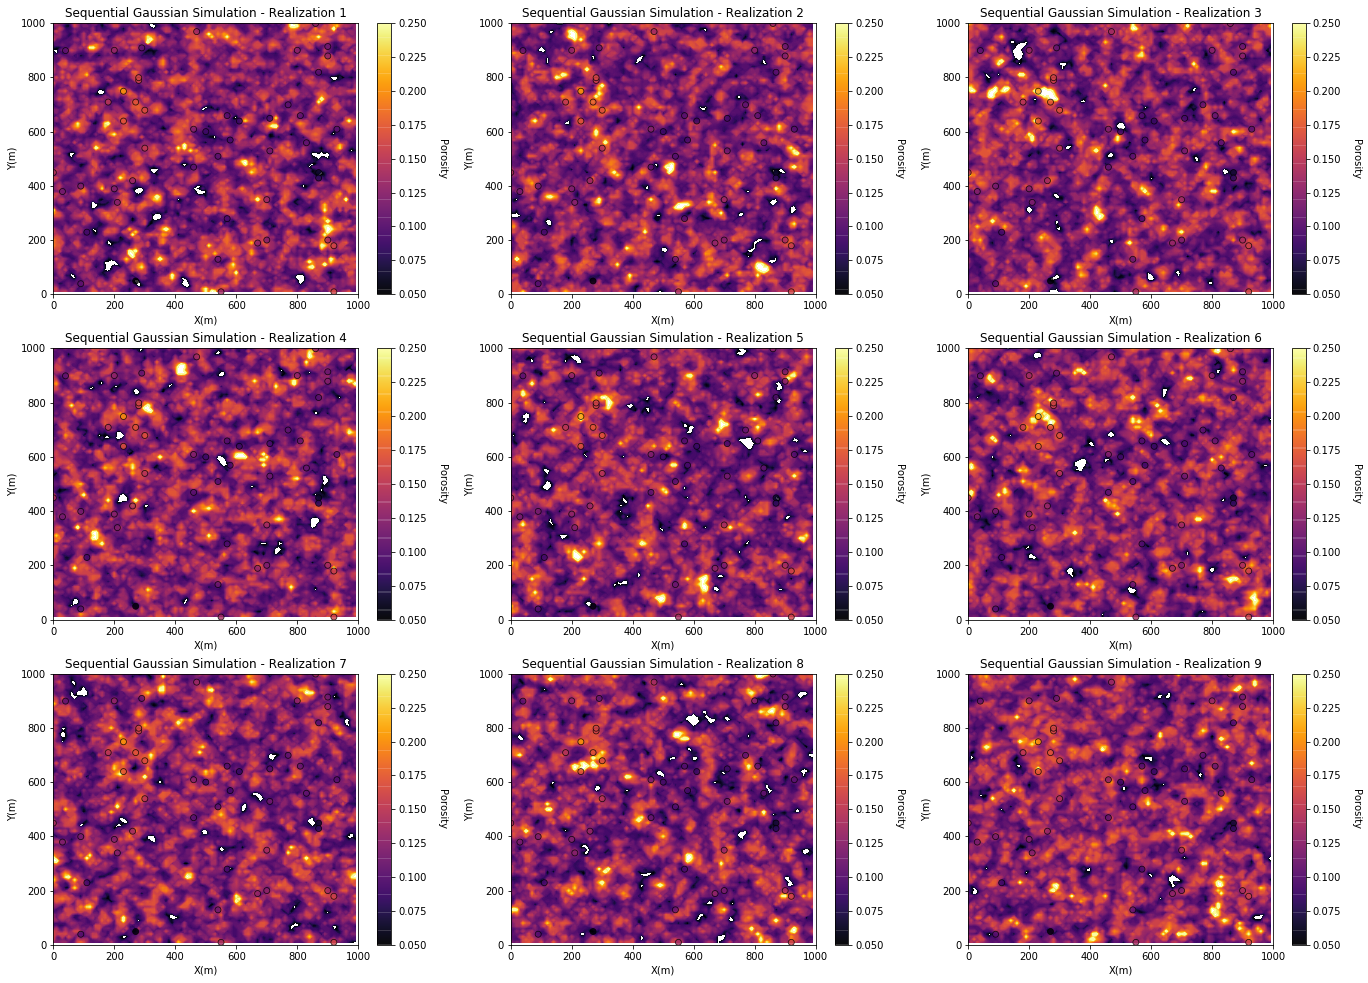

In [28]:
# Demonstration of Multiple Realizations - Short Continuity
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno

ndmin = 0; ndmax = 10; radius = 50; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=50,hmin1=50)
tmin = -999; tmax = 999

nreal = 20                               # number of bootstrap realizations                             
realizations = np.zeros((ny,nx,nreal));

for ireal in range(0,nreal):
    realizations[:,:,ireal] = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073 + ireal,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

for ireal in range(0,min(nreal,9)):
    plt.subplot(3,3,ireal+1)
    GSLIB.locpix_st(realizations[:,:,ireal],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization ' + str(ireal+1),'X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.2, wspace=0.2, hspace=0.2)
plt.show()


#### Summarizing Local Uncertainty with the POSTSIM Method

Let's run the POSTSIM algorithm. It simply loops over all the locations ix and iy and calculates local summary statistics to quantify the local uncertainty.

We will start with the e-type and the conditional variance.  

* **e-type** is the local expectation (just the average of the $L$ realizations at location $\bf{u}_{\alpha}$ as we assume all realizations are equally likely).
* **conditional variance** is the local variance  

Note, we just have to run the program once because both of these outputs are included together.

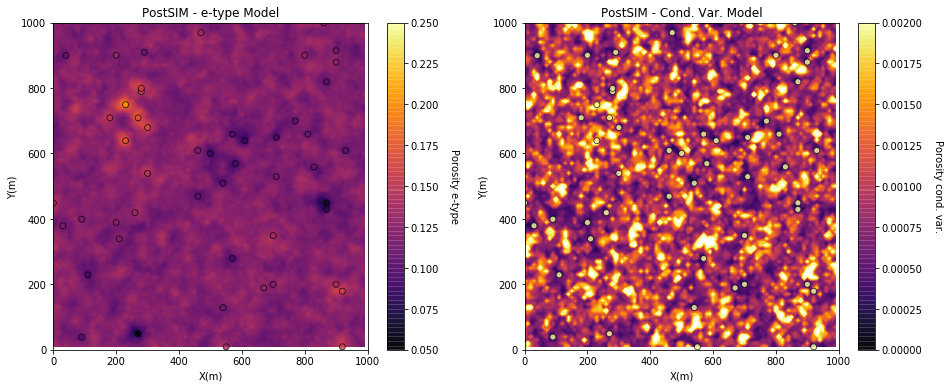

In [50]:
z_value = -999; cdf_value = 0.5     # not used for this step

[e_type, c_var, prob, prob_not,slice_values_ex, slice_values_noex,
 z_type, z_type_low, z_type_high]=postsim(realizations, z_value, cdf_value)

plt.subplot(2,2,1)
GSLIB.locpix_st(e_type,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','PostSIM - e-type Model','X(m)','Y(m)','Porosity e-type',cmap)

plt.subplot(2,2,2)
GSLIB.locpix_st(c_var,xmin,xmax,ymin,ymax,xsiz,0.0,0.002,df,'X','Y','Porosity','PostSIM - Cond. Var. Model','X(m)','Y(m)','Porosity cond. var.',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()


Now let's look at the:

* **local percentile** maps are the maps with the local percentile values sampled from the local realizations

We can interprete them as follows, at a location if we have a local P10 of 14% porosity, then we have a 90% probability of an even higher porosity, the porosity at that location is surely high.

Local percentiles are very convenient to understand local uncertainty.  We must make sure that we do not mix them up with a percentile model (the model that is globally ranked as a specific percentile outcome.

Note: we have to run the program for each percentile, we specify this as the *cdf_value* input.

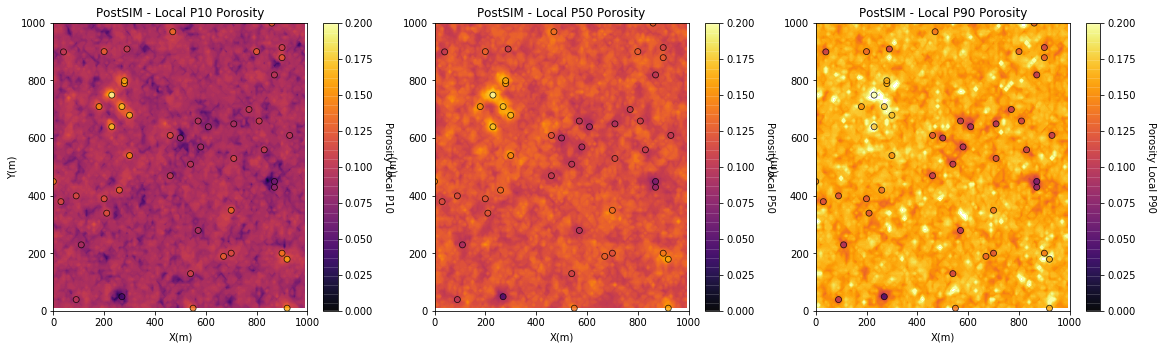

In [67]:
z_value = -999;     # not used for this step

cdf_value = 0.1     # percentile value
[e_type, c_var, prob, prob_not,slice_values_ex, slice_values_noex,
 z_type10, z_type_low, z_type_high]=postsim(realizations, z_value, cdf_value)

cdf_value = 0.5    
[e_type, c_var, prob, prob_not,slice_values_ex, slice_values_noex,
 z_type50, z_type_low, z_type_high]=postsim(realizations, z_value, cdf_value)

cdf_value = 0.9     
[e_type, c_var, prob, prob_not,slice_values_ex, slice_values_noex,
 z_type90, z_type_low, z_type_high]=postsim(realizations, z_value, cdf_value)

plt.subplot(1,3,1)
GSLIB.locpix_st(z_type10,xmin,xmax,ymin,ymax,xsiz,0.0,.2,df,'X','Y','Porosity','PostSIM - Local P10 Porosity','X(m)','Y(m)','Porosity Local P10',cmap)

plt.subplot(1,3,2)
GSLIB.locpix_st(z_type50,xmin,xmax,ymin,ymax,xsiz,0.0,.2,df,'X','Y','Porosity','PostSIM - Local P50 Porosity','X(m)','Y(m)','Porosity Local P50',cmap)

plt.subplot(1,3,3)
GSLIB.locpix_st(z_type90,xmin,xmax,ymin,ymax,xsiz,0.0,.2,df,'X','Y','Porosity','PostSIM - Local P90 Porosity','X(m)','Y(m)','Porosity Local P90',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1., wspace=0.2, hspace=0.2)
plt.show()

Now we will look at the: 

* **probability of exceedance** where we specify a threshold porosity value and calculate the probability of exceeding that value at all locations.

We will typically select critical thresholds, such as a net-to-gross threshold.

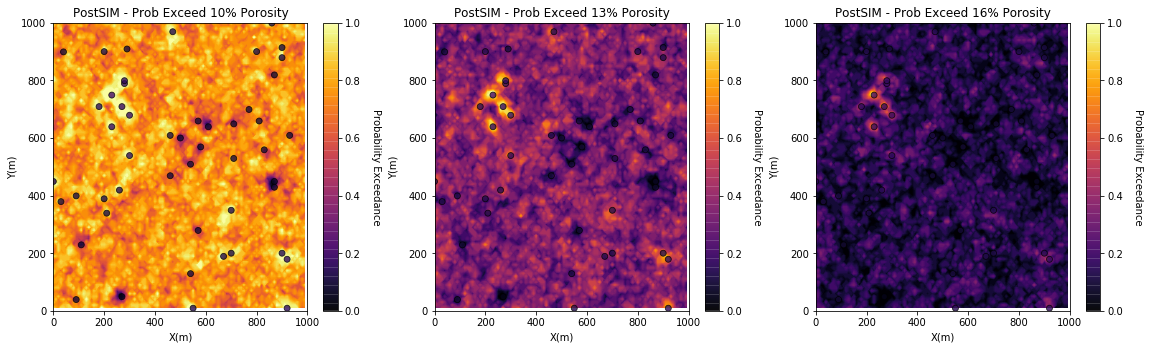

In [66]:
cdf_value = 0.5;     # not used for this step

z_value = 0.1        # percentile value
[e_type, c_var, prob10, prob_not,slice_values_ex, slice_values_noex,
 z_type, z_type_low, z_type_high]=postsim(realizations, z_value, cdf_value)

z_value = 0.13       # percentile value
[e_type, c_var, prob13, prob_not,slice_values_ex, slice_values_noex,
 z_type, z_type_low, z_type_high]=postsim(realizations, z_value, cdf_value)

z_value = 0.16       # percentile value
[e_type, c_var, prob16, prob_not,slice_values_ex, slice_values_noex,
 z_type, z_type_low, z_type_high]=postsim(realizations, z_value, cdf_value)

plt.subplot(1,3,1)
GSLIB.locpix_st(prob10,xmin,xmax,ymin,ymax,xsiz,0.0,1.,df,'X','Y','Porosity','PostSIM - Prob Exceed 10% Porosity','X(m)','Y(m)','Probability Exceedance',cmap)

plt.subplot(1,3,2)
GSLIB.locpix_st(prob13,xmin,xmax,ymin,ymax,xsiz,0.0,1.,df,'X','Y','Porosity','PostSIM - Prob Exceed 13% Porosity','X(m)','Y(m)','Probability Exceedance',cmap)

plt.subplot(1,3,3)
GSLIB.locpix_st(prob16,xmin,xmax,ymin,ymax,xsiz,0.0,1.,df,'X','Y','Porosity','PostSIM - Prob Exceed 16% Porosity','X(m)','Y(m)','Probability Exceedance',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1., wspace=0.2, hspace=0.2)
plt.show()


#### Comments

This was a basic demonstration of summarizing local uncertainty with multiple realizations. Much more could be done.  I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin